In [ ]:
import pandas as pd
import numpy as np
# from scipy.stats import randint

from matplotlib import pyplot as plt
# plt.style.use('dark_background')

# pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

import yaml
from joblib import dump

import functions    # local functions in this repository

In [2]:
with open("config.ini", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

clm = cfg['column names database']

load data

In [3]:
transactions = pd.read_csv( cfg['CSV filenames']['database']  + '.csv', encoding = 'ISO-8859-1' )
transactions[clm['date']] = pd.to_datetime( transactions[clm['date']] , format = cfg['date format'] )

transactions.shape

(4364, 6)

filter dataset

In [ ]:
# no detailed description text (Finanzmanager export)
transactions = transactions[ ~transactions[clm['type']].isna() ]

# not used anymore
transactions = transactions[ ~transactions[clm['category']].isin(
    [
        # fill in names of not used categories here
    ]) ]

transactions.shape

(3612, 6)

inspect labels

In [ ]:
categories = (
    transactions.groupby(clm['category'])
      .agg(
          count=(clm['category'], 'count'),
          money_sum=(clm['amount'], 'sum'),
          last_used=(clm['date'], 'max')
      ).reset_index())

categories.sort_values(by='count', ascending=True)

split train & test data

In [6]:
transactions_train, transactions_test = train_test_split(
    transactions, test_size=0.2, stratify=transactions[clm['category']],
    random_state=42)

y_train = transactions_train[clm['category']]

transactions_train.shape

(2889, 6)

inspect features

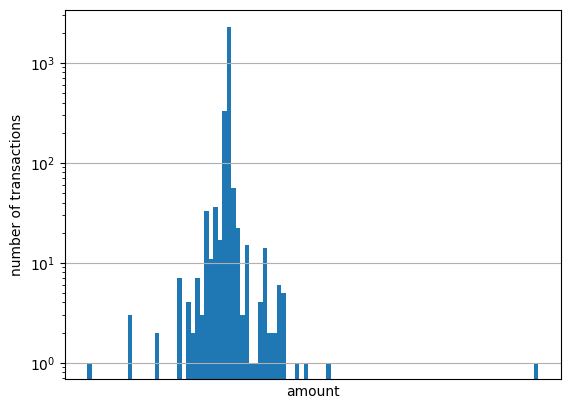

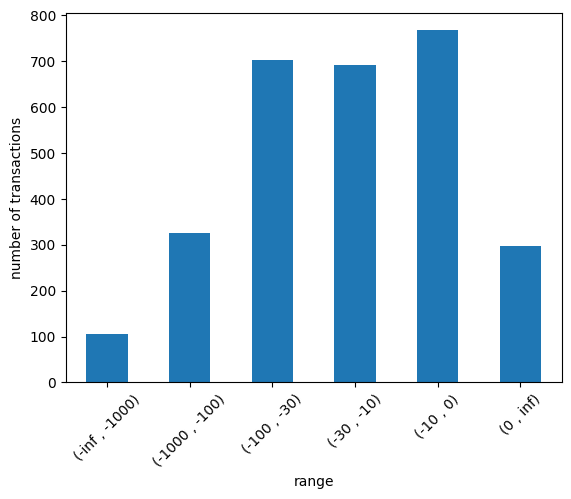

In [ ]:
transactions_train[clm['amount']].hist(bins = 100 )
plt.yscale('log')
plt.xlabel("amount")
plt.ylabel("number of transactions")
# plt.xticks([])
plt.show()


bins = [-np.inf, -1000, -100, -30, -10, 0, np.inf]
transactions_train["amount_cat"] = pd.cut(transactions_train[clm['amount']], bins=bins, labels = range(len(bins)-1))

transactions_train["amount_cat"].value_counts().sort_index().plot.bar(rot=45)
plt.xlabel("range")
plt.ylabel("number of transactions")
plt.gca().set_xticklabels([f'({bins[i]} , {bins[i+1]})' for i in range(len(bins)-1) ])
plt.show()

pre-processing & model pipeline

In [ ]:
textpreprocessing = make_pipeline(
    functions.CleanTexts(threshold = 90, max_edits = 3) ,
    CountVectorizer(
        token_pattern=r"(?u)\b\w{4,}\b" ,    # min word length
        ngram_range=(1,3) ,                  # number of consecutive words
        min_df = 1 ,                         # min word frequency
        binary=True ,                        # vector output: occurrence only or word counts
        )
)

preprocessing = make_column_transformer(
    (textpreprocessing, clm['text']) ,
    # (functions.CyclicalEncoder(period=[31]), ["day"]) ,
    # (functions.CyclicalEncoder(period=[12]), ["month"]) ,
    # (functions.CyclicalEncoder(period=[31,12]), ["day","month"]) ,
    ('passthrough', ['day', 'month']) ,
    (StandardScaler(), [clm['amount']]) ,
    # ('passthrough', ['amount_cat'])
)

classifier = make_pipeline(
    functions.DayMonth(clm['date'], cfg['date format']) ,
    preprocessing , 
    RandomForestClassifier(n_estimators = 100)
)

classifier.fit(transactions_train, y_train)

Pipeline(steps=[('daymonth', DayMonth(col='Datum', format='%d.%m.%Y')),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('cleantexts',
                                                                   CleanTexts(max_edits=3,
                                                                              threshold=90)),
                                                                  ('countvectorizer',
                                                                   CountVectorizer(binary=True,
                                                                                   ngram_range=(1,
                                                                                                3),
                                                                                   token_pattern='(?u)\\b\\w{4,}\\b'))]),
                                                  'Buchungstext'),
                                                 ('passthrough', 'passthrough',
                                                  ['day', 'month']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Betrag'])])),
                ('randomforestclassifier', RandomForestClassifier())])

vocabulary

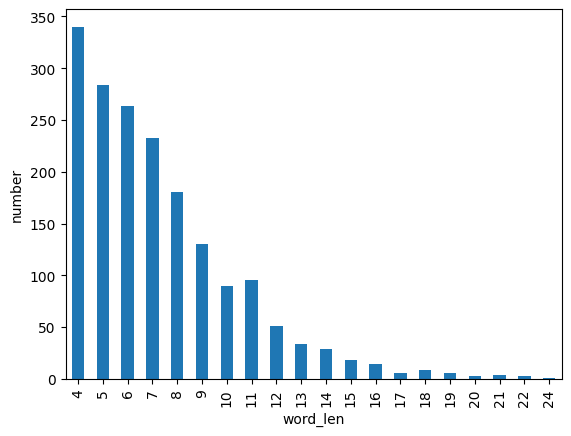

In [ ]:
textpreprocessor = classifier['columntransformer']['pipeline']['cleantexts']

vocabulary = pd.DataFrame(textpreprocessor.vocabulary_, columns=['word'])
vocabulary['word_len'] = vocabulary['word'].str.len()

vocabulary["word_len"].value_counts().sort_index().plot.bar()
plt.ylabel("number")
plt.show()

unique_chars = set(''.join(transactions_train[clm['text']].values))
unique_chars_sorted = sorted(unique_chars)
print(unique_chars_sorted)

textpreprocessor.conversions_

feature importances (Random Forest only)

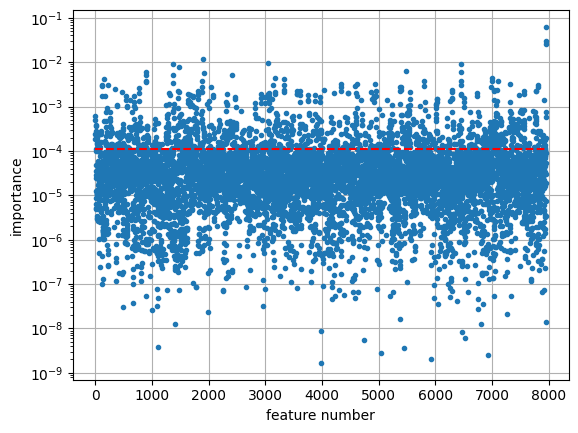

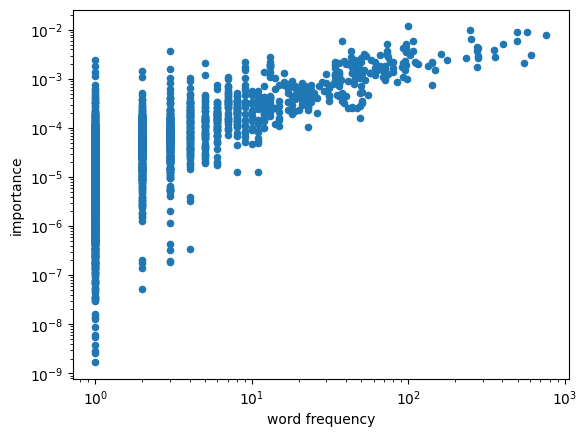

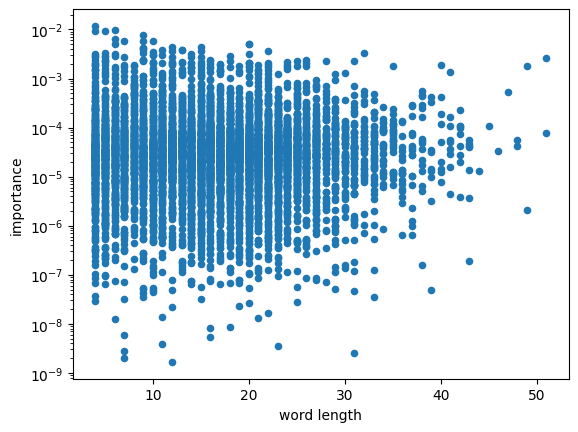

In [ ]:
feature_importances = classifier['randomforestclassifier'].feature_importances_

vectorizer = classifier['columntransformer']['pipeline']['countvectorizer']
X_text = vectorizer.transform(transactions_train[clm['text']])
mf = X_text.shape[1]

words_importance = pd.DataFrame({
    'word': vectorizer.get_feature_names_out() ,
    'importance': feature_importances[:mf] ,
    'frequency' : np.asarray(X_text.sum(axis=0)).ravel()
    }).sort_values(by='importance', ascending=False)
words_importance['word_len'] = words_importance['word'].str.len()

plt.semilogy(feature_importances,'.')
plt.hlines(y=(feature_importances[:mf].mean()), xmin=0, xmax=mf, colors='r', linestyles='dashed')
# plt.xlim([mf,len(feature_importances)])
plt.xlabel('feature number')
plt.ylabel('importance')
plt.grid()
plt.show()

words_importance.plot(x='frequency', y='importance', kind='scatter', loglog=True)
plt.xlabel('word frequency')
plt.show()

words_importance.plot(x='word_len', y='importance', kind='scatter', logy=True)
plt.xlabel('word length')
plt.show()

words_importance

hyperparameter tuning

In [12]:
# for key in classifier.get_params().keys():
#     print(key)


# param_distribs = {
#       'columntransformer__pipeline__countvectorizer__token_pattern' : [r"(?u)\b\w{2,}\b", r"(?u)\b\w{3,}\b", r"(?u)\b\w{4,}\b", r"(?u)\b\w{5,}\b"] , # min word length
#       'columntransformer__pipeline__countvectorizer__ngram_range' : [(1,1), (1,2), (1,3), (1,4)] ,  # number of consecutive words
#       'columntransformer__pipeline__countvectorizer__min_df' : randint(low=1, high=5) ,                   # min word frequency
#       'columntransformer__pipeline__countvectorizer__binary' : [True, False] ,                             # vector output: occurrence only or word counts
#       'columntransformer__pipeline__cleantexts__max_edits' : [1, 2, 3] ,
#       'columntransformer__pipeline__cleantexts__threshold' : range(80,100,5) ,
#       'randomforestclassifier__n_estimators' : randint(low=50, high=300) ,                        # number of decision trees
#     }


# rnd_search = RandomizedSearchCV(
#     classifier, param_distributions=param_distribs, n_iter=100, cv=5, random_state=42)

# rnd_search.fit(transactions_train, y_train)


# classifier = rnd_search.best_estimator_

# print(rnd_search.best_params_)

# param_keys = ['param_' + key for key in param_distribs] + ['mean_test_score']
# results = pd.DataFrame(rnd_search.cv_results_)[param_keys].sort_values(by='mean_test_score', ascending=False)
# results['mean_test_score'] = (results['mean_test_score'] * 100).round(1)
# results

cross-validation & confusion matrix

c:\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Mean accuracy: 77.54 %


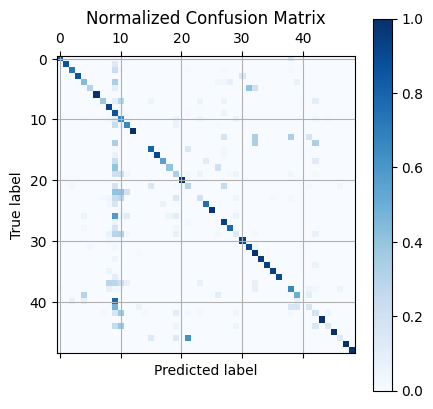

In [13]:
y_pred   = cross_val_predict(classifier, transactions_train, y_train, cv=5)    # uses stratified k-fold by default
conf_mat = confusion_matrix(y_train, y_pred)
total_per_category  = conf_mat.sum(axis=1)
conf_mat_normalized = conf_mat.astype('float') / total_per_category[:, np.newaxis]

print(f'Mean accuracy: {np.mean(y_pred == y_train)*100:.2f} %')

plt.matshow(conf_mat_normalized, cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.grid()
plt.show()

In [ ]:
confusion = pd.DataFrame({
    clm['category'] : classifier.classes_ ,
    'accuracy'      : np.round(np.diag(conf_mat_normalized) * 100,1) ,
    'errors'        : total_per_category - np.diag(conf_mat)
})

categories = categories.merge(confusion, on=clm['category'], how='left')

categories[clm['category']].to_csv( cfg['CSV filenames']['categories'] + '.csv', encoding = "ISO-8859-1", index=0, header=0 )

categories.sort_values(by='accuracy', ascending=True)

In [ ]:
# mask out diagonal
mask = ~np.eye(conf_mat_normalized.shape[0], dtype=bool)

# get flat index of the largest off-diagonal element
# flat_idx = np.argsort(conf_mat[mask])[-5:][::-1]      # sort by number of errors
flat_idx = np.argsort(conf_mat_normalized[mask])[-5:][::-1]     # sort by error ratio

# map flat index back to 2D indices
rows, cols = np.where(mask)
i, j = rows[flat_idx], cols[flat_idx]

print('top confusion between categories:')
for idx in range(len(i)):
    print(f'{conf_mat[ i[idx], j[idx] ]}/{total_per_category[i[idx]]} ' +
          f'{classifier.classes_[i[idx]]} --> {classifier.classes_[j[idx]]}')

save classifier

In [ ]:
dump(classifier, cfg['categorizer file'] + '.joblib')

final test

In [17]:
y_test = transactions_test[clm['category']]
y_test_pred = classifier.predict(transactions_test)

print(f'Mean accuracy: {np.mean(y_test_pred == y_test)*100:.2f} %')

Mean accuracy: 79.53 %
